<a href="https://colab.research.google.com/github/Bibhash123/Estimation-of-NO2-Concentration-for-Sparse-Data/blob/main/Model-Training/GRSL_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
from google.colab import files
_ = files.upload()
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d bibhash123/grsldata
!unzip grsldata.zip -d "/content/dataset"
!rm grsldata.zip
from IPython.display import clear_output
clear_output(wait=False)

In [ ]:
!pip uninstall -y shapely
!pip uninstall -y cartopy
!pip install shapely cartopy --no-binary shapely --no-binary cartopy
clear_output(wait=False)

In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import os
import gc
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
# import utils

SEED=123
def seedAll(seed):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ["PYTHONHASHSEED"]=str(seed)

seedAll(SEED)

In [ ]:
files = pd.read_csv("/content/dataset/files.csv").sample(frac=1).reset_index(drop=True)

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True)
files.loc[:,'Fold'] = -1

for fold,(i_trn,i_val) in enumerate(kf.split(files)):
  files.loc[i_val,"Fold"] = fold

# files.to_csv("files.csv",index=False)
# !rm -r "/content/dataset/files.csv"
# !cp "files.csv" "/content/dataset/files.csv"
# !kaggle datasets init -p "/content/dataset"
# _ = input("Press any Key to continue")
# !kaggle datasets version -p "/content/dataset" --dir-mode tar -m "Update"
# # train_files,val_files = train_test_split(files,test_size=0.2)

In [ ]:
def pearson(y_true,y_pred):
  if len(y_true.shape)!=1:
    true = []
    for i in range(y_true.shape[0]):
      true.extend(y_true[i])
    pred = []
    for i in range(y_pred.shape[0]):
      pred.extend(y_pred[i])
  else:
    true=y_true
    pred=y_pred
  return np.mean((np.array(true)-np.mean(true))*(np.array(pred)-np.mean(pred)))/(np.std(np.array(true))*np.std(np.array(pred)))

def pearsonCorrAvgDays(true,pred):
  # assert len(true.shape)>=3,"true must have at least 3 dimensions, found {}".format(len(true.shape))
  assert true.shape==pred.shape, "true and pred must have same shape, found {} and {}".format(true.shape,pred.shape)
  scores = []
  for i in range(true.shape[0]):
    scores.append(pearson(true[i],pred[i]))
  return np.mean(scores),scores

def pearsonCorrAvgPixels(true,pred):
  scores = []
  for i in range(true.shape[1]):
    scores.append(pearson(true[:,i],pred[:,i]))
  return np.mean(scores),scores

# Univariate

In [ ]:
def loadData(df,satdir = "/content/dataset/Satellite",gdir = "/content/dataset/Ground"):
  X = []
  Y = []
  for i in range(df.shape[0]):
    factor = 1
    sat = np.expand_dims(factor*np.load(os.path.join(satdir,df["Sat_file"].iloc[i])),axis=2)      
    ground = np.load(os.path.join(gdir,df["Ground_file"].iloc[i])).flatten()
    if not np.isnan(np.sum(sat)) and not np.isnan(np.sum(ground)):
      if not np.std(ground)==0:
        X.append(sat)
        Y.append(ground)
  return np.stack(X,axis=0),np.stack(Y,axis=0)

In [ ]:
# def build_model(X_train):
#   inp = L.Input(shape=X_train[0].shape)
#   h = L.Conv2D(16,(3,3),activation="linear",padding="same")(inp)
#   h = L.Conv2D(16,(3,3),activation="linear")(h)
#   h = L.Conv2D(32,(3,3),activation="linear")(h)
#   out = L.Flatten()(h)
#   out = L.Dense(100,activation="linear")(out)
#   out = L.Dense(np.prod(X_train[0].shape),activation="linear")(out)
#   model = Model(inputs=inp,outputs=out)
#   model.compile(optimizer=Adam(learning_rate=0.001),loss="mse",
#                 metrics=[RootMeanSquaredError()])
  
#   return model
def build_model(X_train):
  inp = L.Input(shape=X_train[0].shape)
  h = L.Conv2D(16,(3,3),activation="linear",padding="same")(inp)
  h = L.Conv2D(16,(3,3),activation="linear")(h)
  h = L.MaxPooling2D(pool_size = (2,2),strides =2)(h)
  # h = L.Conv2D(16,(3,3),activation="linear")(h)
  # h = L.Conv2D(32,(3,3),activation="linear")(h)
  out = L.Flatten()(h)
  out = L.Dense(100,activation="linear")(out)
  out = L.Dense(np.prod(X_train[0].shape),activation="linear")(out)
  model = Model(inputs=inp,outputs=out)
  model.compile(optimizer=Adam(learning_rate=0.001),loss="mse",
                metrics=[RootMeanSquaredError()])
  
  return model

In [ ]:
scores_list = []
rmses = []
maes = []

for fold in range(5):
  print("\nFold {}\n".format(fold))
  train_files = files[files["Fold"]!=fold]
  val_files = files[files["Fold"]==fold]

  X_train,Y_train = loadData(train_files)
  X_val,Y_val = loadData(val_files)
  # loss_plt = utils.loss_plt()
  K.clear_session()
  model = build_model(X_train)
  if fold==0:
    print(model.summary())
  ckpt = ModelCheckpoint(f"model_{fold}.hdf5",monitor="val_root_mean_squared_error",mode="min",save_best_only=True,save_weights_only=True)
  model.fit(X_train,Y_train,
            epochs=50,
            verbose=0,
            batch_size=8,
            validation_data = (X_val,Y_val),
            callbacks=[ckpt])
  model.load_weights(f"model_{fold}.hdf5")
  rmse = mean_squared_error(Y_val,model.predict(X_val),squared=False)
  rmses.append(rmse)
  mae = mean_absolute_error(Y_val,model.predict(X_val))
  maes.append(mae)

  print("Fold {} RMSE Score: {}".format(fold, rmse))
  s,ls = pearsonCorrAvgDays(Y_val,model.predict(X_val))
  print("Fold {} Pearson coeff avg over days: {}".format(fold,np.mean([i for i in ls if not pd.isnull(i)])))
  scores_list.append(ls)
  if fold!=4:
    del model
    _ = gc.collect()
print("\nCV RMSE Score: {}".format(np.mean(rmses)))
print("\nCV MAE Score: {}".format(np.mean(maes)))


Fold 0

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 49, 67, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 49, 67, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 65, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 32, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 11776)             0         
                                                                 
 dense (Dense)               (None, 100)               1177700   
                                                    

In [ ]:
model.load_weights("model_4.hdf5")

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image

def plotMap(grid,lon,lat,extent,title,figname):
  
  def image_spoof(self, tile): # this function pretends not to be a Python script
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

  cimgt.QuadtreeTiles.get_image = image_spoof # reformat web request for street map spoofing
  osm_img = cimgt.QuadtreeTiles() # spoofed, downloaded street map
  fig = plt.figure(figsize=(12,9)) # open matplotlib figure
  plt.rcParams["font.size"] = 18
  ax1 = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map
  zoom = 0.00075 # for zooming out of center point
  # extent = [np.min(lon),np.max(lon),np.min(lat),np.max(lat)] # adjust to zoom
  #extent = [-6.4,-6.11,53.282,53.4]
  ax1.set_extent(extent) # set extents

  scale = np.ceil(-np.sqrt(2)*np.log(np.divide((extent[1]-extent[0])/2,350.0))) # empirical solve for scale based on zoom
  scale = (scale<20) and scale or 19# scale cannot be larger than 19
  ax1.add_image(osm_img, int(scale))# add OSM with zoom specification
  # NOTE: zoom specifications should be selected based on extent:
  # -- 2     = coarse image, select for worldwide or continental scales
  # -- 4-6   = medium coarseness, select for countries and larger states
  # -- 6-10  = medium fineness, select for smaller states, regions, and cities
  # -- 10-12 = fine image, select for city boundaries and zip codes
  # -- 14+   = extremely fine image, select for roads, blocks, buildings
  my_cmap = plt.cm.get_cmap("jet")
  c = plt.pcolormesh(lon,lat,grid,transform=ccrs.PlateCarree(),cmap=my_cmap,alpha=0.6)
  fig.colorbar(c,extend="both",label="ug/m3")
  plt.title(title)
  plt.savefig(f'{figname}.pdf')
  plt.show() # show the plot
  return ax1

In [ ]:
def plotPreds(date,data,model,satdir,grounddir):
  pred = np.zeros((3*49,14*67))
  true = np.zeros((3*49,14*67))
  min_lon, min_lat = (-9.45, 35.05)
  max_lon, max_lat = (39.65000000000001, 69.65)
  cols,rows = (int((max_lon-min_lon)//0.05), int((max_lat-min_lat)//0.05))
  latitudes = list(np.linspace(min_lat,max_lat+0.05,rows))[:147]
  longitudes = list(np.linspace(min_lon,max_lon+0.05,cols))[:938]
  extent = [min_lon-1,max_lon+1,min_lat-1,max_lat-15]

  df = data[data["Date"]==date].copy()
  for patch in range(1,43):
    row,col = ((patch-1)//14)+1,((patch-1)%14)+1
    true[(row-1)*49:row*49,(col-1)*67:col*67] = np.load(os.path.join(grounddir,f"grnd_{patch}_{date}.npy"))
    pred[(row-1)*49:row*49,(col-1)*67:col*67] = model.predict(np.stack([np.load(os.path.join(satdir,f"sat_{patch}_{date}.npy"))])).reshape((49,67))
  
  plotMap(true,longitudes,latitudes,extent,"","fig1")
  plotMap(pred,longitudes,latitudes,extent,"","fig2")

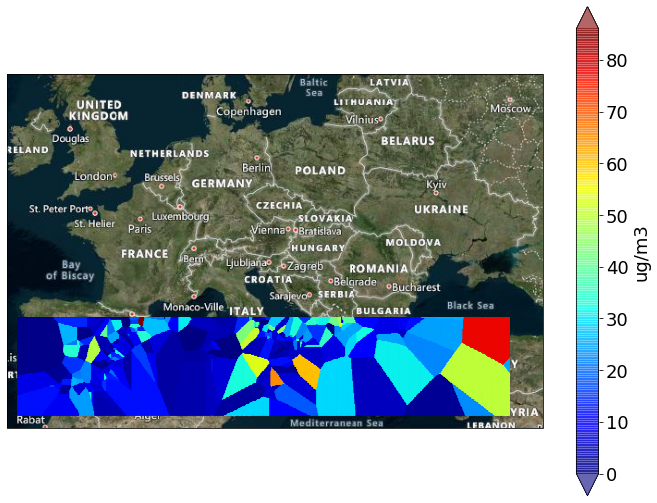

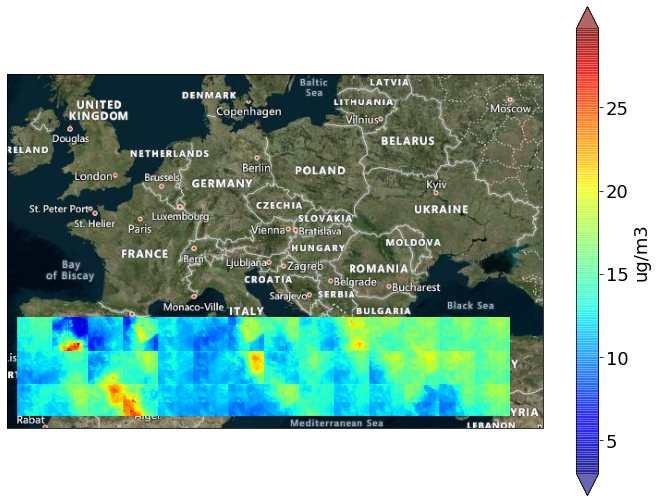

In [ ]:
plotPreds("2018-12-23",files,model,
          "/content/dataset/Satellite",
          "/content/dataset/Ground")

In [ ]:
print("CV Pearson's average: {}".format(np.mean([0.6320715442750255,0.6508796854148577,0.6691547124487071,0.6463206505606328,0.648193465151463])))

CV Pearson's average: 0.6493240115701372
